
# Trabalho Prático 1: Reconhecimento de Cartão-Resposta

Esthefanie Pessoa Lanza - 2015112736
João Antônio Dornelas Orlando Netto - 2014103407

19/09/2017


Primeiramente, importamos todas as bibliotecas necessárias e, através de um path, abrimos uma imagem e a salvamos na variável img.

In [5]:
#Bibliotecas utilizadas
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Caminho da magem
imagePath = 'pattern_0001_scan.png';
img = cv2.imread(imagePath);

#Dimensões da imagem
altura, largura = img.shape[:2]


Declaramos uma função para impressão da imagem, e imprimimos a imagem importada anteriormente.

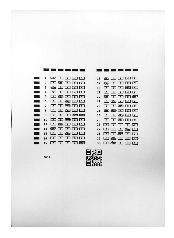

In [6]:
#Impressão da imagem na tela
def printImage( img ):
    plt.imshow(img, cmap = 'gray')
    plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    plt.show()   
    return

printImage(img);

A biblioteca openCV lê os pixels em formato BGR, porém utilizaremos tons de cinza para análise da imagem. Dessa forma, convertemos a imagem para o padrão de cores desejado antes de utilizar as outras funções. Em seguida, aplicamos o filtro da mediana para remover eventuais ruídos que surgiram no processo de conversão.

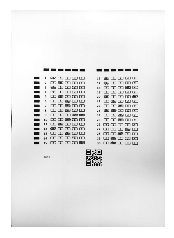

In [7]:
#Conversão do padrão BGR para escala de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Aplicação do filtro da mediana
gray = cv2.medianBlur(gray,5)

printImage(gray)

Precisamos converter todos os tons de cinzas para uma escala binária de preto e branco, logo aplicamos a função de thershold e todos os valores menores que 150 são transformados em branco e todos os valores maiores são transformados em preto. Feito isso, aplicamos um filtro gaussiano para remover eventuais manchas e aplicamos o threshold novamente, dessa vez sem inventer as cores da imagem.

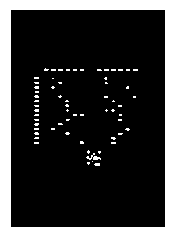

In [8]:
#Aplição do threshold
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
#Aplicação do filtro gaussiano
thresh = cv2.GaussianBlur(thresh,(55,55),0)
#Aplição do threshold
ret, thresh = cv2.threshold(thresh, 127, 255, cv2.THRESH_BINARY)

printImage(thresh)

Com a imagem já tratada, usamos a função colum_stack para encontrar todos os pontos que possuem um threshold maior que 0. Em seguida, usamos a função minAreaRect para encontrar o retângulo mínimo que cerca todos os pontos. Encontramos então o ângulo de rotação da imagem, através da inclinação desse retângulo. 

In [9]:
#Encontra pontos onde threshold é maior que 0
coords = np.column_stack(np.where(thresh > 0))
#Traça o retangulo minimo que abrange todos os pontos
rect = cv2.minAreaRect(coords)
angle = rect[-1]

#Encontra o valor do angulo de rotação
if angle < -45:
	angle = -(90 + angle) 
else:
	angle = -angle

print "Angulo a ser rotacionado: {} graus".format(angle)

Angulo a ser rotacionado: 0.182470023632 graus


Rotacionamos a imagem usando a função getRotationMatrix2d, utilizando como referência o ângulo encontrado anteriormente.

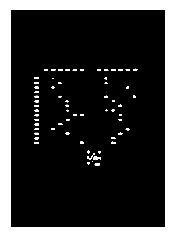

In [10]:
#Encontra dimensões da imagem
(h, w) = img.shape[:2]
center = (w // 2, h // 2)

#Rotaciona imagem em função do valor do angulo fornecido
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(thresh, M, (w, h),
	flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

printImage( rotated )

Com a imagem já rotacionada, cortamos somente  gabarito usando a função boundingRect e escalamos o seu tamanho para que esta seja compátivel com o gabarito original.

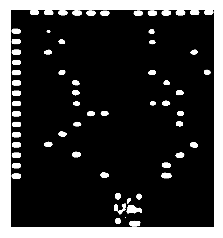

In [11]:
#Encontra pontos que nao sejam zero
points = cv2.findNonZero(rotated)
#Encontra a região que abrange os pontos
hull = cv2.convexHull(points)
x,y,w,h = cv2.boundingRect(hull)
imageResult = rotated[y:y+h,x:x+w]

#Redimensiona a imagem
resized = cv2.resize(imageResult,(806, 866), interpolation = cv2.INTER_CUBIC)

printImage(resized)

Após termos o gabarito contendo a resposta tratado, precisamos verificar se ele não está rotacionada 180º. Isso ocorre porque a rotação que realizamos é baseada na inclinação do retângulo, e não no conteúdo do gabarito. Assim, fazemos uma verificação no conteúdo da imagem, avaliando se o canto superior direito possui os retângulos que demarcam as alternativas "E" e "F" das questões 15 a 30, e caso negativo, rotacionamos a imagem 180º.

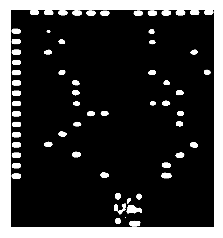

In [12]:
y, y2, x, x2 = 0, 22, 700, 806
corner = resized[y:y2,x:x2]
total = cv2.countNonZero(corner)

if(total < 500):
    #Encontra dimensões da imagem
    (h, w) = resized.shape[:2]
    center = (w // 2, h // 2)

    #Rotaciona imagem 180º graus
    M = cv2.getRotationMatrix2D(center, 180, 1.0)
    resized = cv2.warpAffine(resized, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
printImage(resized)

Particionamos o gabarito em subseções, onde cada subseção representa a resposta marcada para uma questão. No total, são 30 questões, dispostas em 15 linhas e 2 colunas. As respostas são armazenadas em um vetor para posterior análise.

1


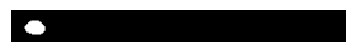

2


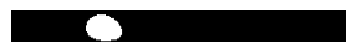

3


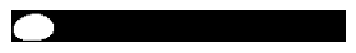

4


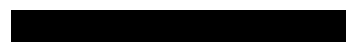

5


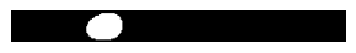

6


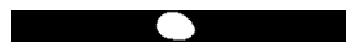

7


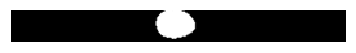

8


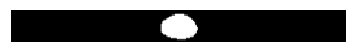

9


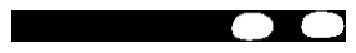

10


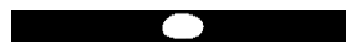

11


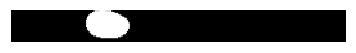

12


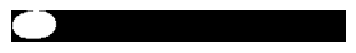

13


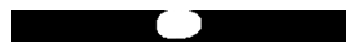

14


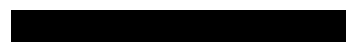

15


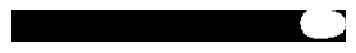

16


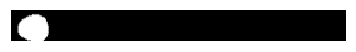

17


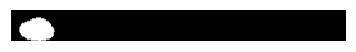

18


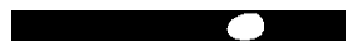

19


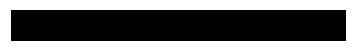

20


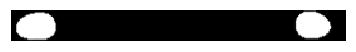

21


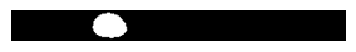

22


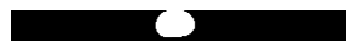

23


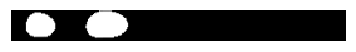

24


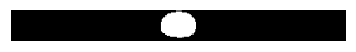

25


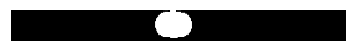

26


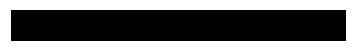

27


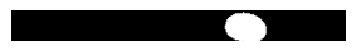

28


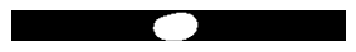

29


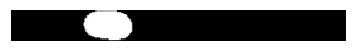

30


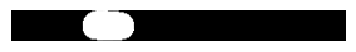

In [13]:
#Cria vetor para armazenar as questões
question = []
questionNumber = 1
y, y2, x, x2 = 75, 100, 130, 390

#Executa rotina para cada linha e cada coluna de respostas
for j in range(0, 2):
    for i in range(0, 15):
        #Imprime na tela a questão e a imagem correspondente
        question.append(resized[y:y2,x:x2])
        print(questionNumber)
        printImage(question[questionNumber-1])
        
        #Incrementa as coordenadas
        y, y2 = y + 41, y2+41
        questionNumber += 1
        
    #Desloca para a segunda coluna
    y, y2, x, x2 = 75, 100, 540, 866


Para cada resposta lida anteriormente, particionamos novamente em 5 subseções, para verificar cada alternativa individualmente. Caso mais de 200 pixels da subseção tenham sido preenchidos, assinalamos que existe uma resposta e a adicionamos no vetor de saída, de acordo com o número da subseção. Caso uma questão possua uma alternativa marcada, e seja identificado que outra alternativa também foi marcada, a questão é anulada. Caso não seja identificada uma subseção preenchida, adicionamos a resposta "Em branco".

In [14]:
answer = []
initial = resized[0:30,130:390]

#Para cada questão lida:
for j in range(0, 30):
    y, y2, x, x2 = 0, 25, 0, 40
    foundAnswer = False
    
    #Para cada subseção da questão
    for i in range(0, 5):
        cropAnswer = question[j][y:y2,x:x2]
        
        #Conta o número de pixels preenchidos
        total = cv2.countNonZero(cropAnswer)
        if(total >= 200):
            #Caso já tenha encontrado outra alternativa marcada, anula a questão
            if(foundAnswer):
                del answer[-1]
                answer.append('Nulo')  
            else:
                #Marca a alternativa com base na subseção analisada
                foundAnswer = True
                answer.append(unichr(i+65))
                
        #Incrementa as coordenadas        
        x, x2 = x+56, x2+56
        
    #Caso nao seja encontrada uma resposta no fim das 5 interações, é assinalado o valor "Branco"
    if(not foundAnswer):
        answer.append('Branco')

#Imprime a resposta para cada uma das alternativas
for i in range(0,30):
    print i+1, ": ", answer[i]

1 :  Branco
2 :  B
3 :  A
4 :  Branco
5 :  B
6 :  C
7 :  C
8 :  C
9 :  Nulo
10 :  C
11 :  B
12 :  A
13 :  C
14 :  Branco
15 :  E
16 :  A
17 :  A
18 :  D
19 :  Branco
20 :  Nulo
21 :  B
22 :  C
23 :  Nulo
24 :  C
25 :  C
26 :  Branco
27 :  D
28 :  C
29 :  B
30 :  B
